In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

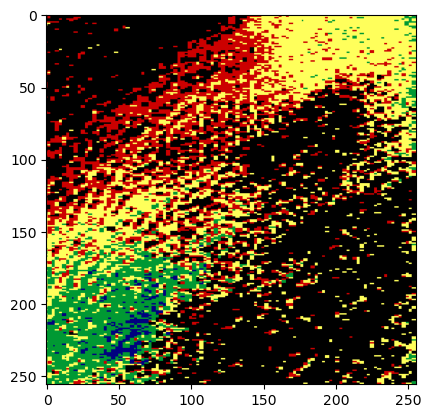

In [3]:
file_path='/kaggle/input/ds-test/Gt/row-1-column-2.png'
img1=Image.open(file_path)
plt.imshow(img1)

In [4]:
len(img1.getbands())

4

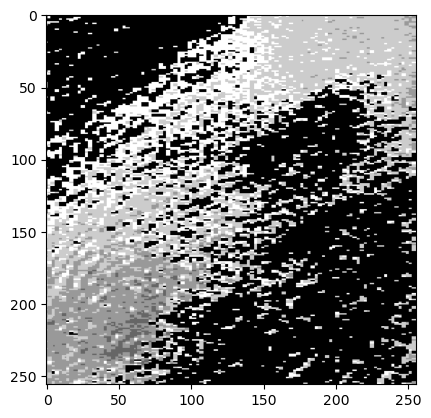

In [5]:
file_path='/kaggle/input/ds-test/Img/row-1-column-2.png'
img=Image.open(file_path)
plt.imshow(img)

In [6]:
len(img.getbands())

4

In [7]:
dataset_gt='/kaggle/input/ds-test/Gt'

In [8]:
len(os.listdir(dataset_gt))

285

In [9]:
0.9*285

256.5

In [10]:
n=np.array(img1)

In [11]:
n.shape

(256, 256, 4)

In [12]:
colors= {
    (0, 0, 0): 0,            # Black
    (255, 255, 91): 1,       # Yellow
    (0, 153, 51): 2,         # Green
    (0, 0, 128): 3,          # Blue
    (204, 0, 0): 4           # Red
}

In [13]:
mask=np.zeros(n.shape[0:2],dtype=np.uint8)

In [14]:
for i in range(n.shape[0]):
    for j in range(n.shape[1]):
        pixel=tuple(n[i,j,:3])
        if pixel in colors:
            label=colors[pixel]
            mask[i,j]=label

In [15]:
mask

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 4, 4, ..., 2, 2, 2],
       [0, 4, 4, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

In [16]:
Imgs='/kaggle/input/ds-test/Img'
gts='/kaggle/input/ds-test/Gt'
Imgs_files=os.listdir(Imgs)
gts_files=os.listdir(gts)
#/kaggle/input/ds-test/Img/row-1-column-1.png
X=[]
for I in Imgs_files:
    #print(I)
    im=Image.open('/kaggle/input/ds-test/Img/'+I)
    im=im.convert('RGB')
    n=np.array(im)
    n=n/255.0
    X.append(n)

In [17]:
Y=[]
#c=0
for I in gts_files:
    #print(I)
    file_path='/kaggle/input/ds-test/Gt/'+I
    im=Image.open(file_path)
    x=np.array(im)
    mask=np.zeros(x.shape[0:2],dtype=np.uint8)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            pixel=tuple(x[i,j,:3])
            if pixel in colors:
                label=colors[pixel]
                mask[i,j]=label
    #print(c)
    Y.append(mask)

In [18]:
len(Y)

285

In [19]:
len(X)

285

In [20]:
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1,random_state=42)
print(len(X_train))
print(len(X_test))

256
29


In [22]:
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate,Conv2DTranspose,BatchNormalization
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [23]:
def Conv_block(Input,n_filters):
    C=Conv2D(n_filters,3,activation='relu',padding='same')(Input)
    X=Conv2D(n_filters,3,activation='relu',padding='same')(C)
    skip_connection=X
    X=BatchNormalization()(X,training=True)
    Nxt_layer=MaxPooling2D(pool_size=(2,2))(X)
    return Nxt_layer,skip_connection

In [24]:
def Decoder_block(prev_layer,skip_layer,n_filters):
    up=Conv2DTranspose(n_filters,(2,2),strides=(2, 2), padding='same')(prev_layer)
    merge=concatenate([up,skip_layer],axis=3)
    conv=Conv2D(n_filters,3,activation='relu',padding='same')(merge)
    conv=BatchNormalization()(conv,training=True)
    conv=Conv2D(n_filters,3,activation='relu',padding='same')(conv)
    return conv

In [25]:
def Unet(input_img):
    c1,s1=Conv_block(input_img,32)
    c2,s2=Conv_block(c1,64)
    Dropout(0.2)(c2)
    c3,s3=Conv_block(c2,128)
    Dropout(0.2)(c3)
    c4,s4=Conv_block(c3,256)
    #Dropout(0.2)(c4)
    c5=Conv2D(512,3,activation='relu',padding='same')(c4)
    c6=Conv2D(512,3,activation='relu',padding='same')(c5)
    u1=Decoder_block(c6,s4,256)
    u2=Decoder_block(u1,s3,128)
    u3=Decoder_block(u2,s2,64)
    u4=Decoder_block(u3,s1,32)
    output=Conv2D(5,(1,1),activation='softmax')(u4)
    model=Model(inputs=[input_img],outputs=output)
    return model


In [26]:
input_img=Input((256,256,3),name='img')
model=Unet(input_img)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [27]:
import tensorflow as tf

In [28]:
"""
X_train=np.reshape(X_train,(-1,256,256,3))
X_test=np.reshape(X_test,(-1,256,256,3))
"""

'\nX_train=np.reshape(X_train,(-1,256,256,3))\nX_test=np.reshape(X_test,(-1,256,256,3))\n'

In [29]:
num_classes=5
Y_train=tf.one_hot(Y_train,depth=num_classes)
Y_test=tf.one_hot(Y_test,depth=num_classes)

In [30]:
def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
    return 1.0 - dice

In [31]:
"""
from tensorflow.keras.utils import to_categorical

num_classes = 5  # Number of classes
Y_train= to_categorical(Y_train, num_classes=num_classes)
Y_test= to_categorical(Y_test, num_classes=num_classes)
"""

'\nfrom tensorflow.keras.utils import to_categorical\n\nnum_classes = 5  # Number of classes\nY_train= to_categorical(Y_train, num_classes=num_classes)\nY_test= to_categorical(Y_test, num_classes=num_classes)\n'

In [32]:
batch_size=32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(batch_size)

In [33]:
def mean_iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return 1.0 - iou

In [34]:
from tensorflow.keras.metrics import MeanIoU

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=mean_iou_loss, metrics=['accuracy'])
results =model.fit(train_dataset, batch_size=32, epochs=135, validation_data=test_dataset)

Epoch 1/135
8/8 [==============================] - 28s 664ms/step - loss: 0.6317 - accuracy: 0.5602 - val_loss: 0.4076 - val_accuracy: 0.7672
Epoch 2/135
8/8 [==============================] - 3s 358ms/step - loss: 0.4294 - accuracy: 0.7592 - val_loss: 0.2858 - val_accuracy: 0.8658
Epoch 3/135
8/8 [==============================] - 3s 328ms/step - loss: 0.3425 - accuracy: 0.8048 - val_loss: 0.2703 - val_accuracy: 0.8493
Epoch 4/135
8/8 [==============================] - 3s 325ms/step - loss: 0.3237 - accuracy: 0.8145 - val_loss: 0.2581 - val_accuracy: 0.8561
Epoch 5/135
8/8 [==============================] - 3s 335ms/step - loss: 0.3040 - accuracy: 0.8277 - val_loss: 0.2191 - val_accuracy: 0.8801
Epoch 6/135
8/8 [==============================] - 3s 323ms/step - loss: 0.2859 - accuracy: 0.8366 - val_loss: 0.2215 - val_accuracy: 0.8777
Epoch 7/135
8/8 [==============================] - 3s 332ms/step - loss: 0.2819 - accuracy: 0.8386 - val_loss: 0.2131 - val_accuracy: 0.8824
Epoch 8/135


In [36]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 143ms/step - loss: 0.0568 - accuracy: 0.9743


[0.05683410167694092, 0.9742831587791443]

In [37]:
a=np.reshape(X_test,(-1,256,256,3))

In [38]:
Y_pred=model.predict(a)

1/1 [==============================] - 0s 395ms/step


In [39]:
Y_pred.shape

(29, 256, 256, 5)

In [40]:
Y_pred=np.argmax(Y_pred,axis=-1)

In [41]:
Y_pred.shape

(29, 256, 256)

In [42]:
Y_pred[0]

array([[0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 3, 3, 3]])

In [43]:
Y=np.argmax(Y_test,axis=-1)

In [44]:
Y.shape

(29, 256, 256)

In [45]:
sum(Y==Y_pred)

array([[26, 23, 26, ..., 23,  7, 26],
       [26, 27, 29, ..., 27, 26, 23],
       [26, 28, 28, ..., 25, 23, 24],
       ...,
       [26, 28, 28, ..., 26, 28, 23],
       [26, 28, 29, ..., 29, 27, 27],
       [ 2, 24, 24, ..., 20,  3,  3]])

In [46]:
colors = {
    0: (0, 0, 0),          # Black
    1: (255, 255, 91),     # Yellow
    2: (0, 153, 51),       # Green
    3: (0, 0, 128),        # Blue
    4: (204, 0, 0)         # Red
}


In [47]:
def mask_to_rgb(mask,color_dict):
    h,w=mask.shape
    rgb_img=np.zeros((h,w,3),dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            class_index=int(mask[i,j])
            rgb_color=color_dict.get(class_index,(0,0,0))
            rgb_img[i,j,:]=rgb_color
    return rgb_img

In [48]:
rgb_images_pred=[mask_to_rgb(mask, colors) for mask in Y_pred]

In [49]:
rgb_real=[mask_to_rgb(mask, colors) for mask in Y]

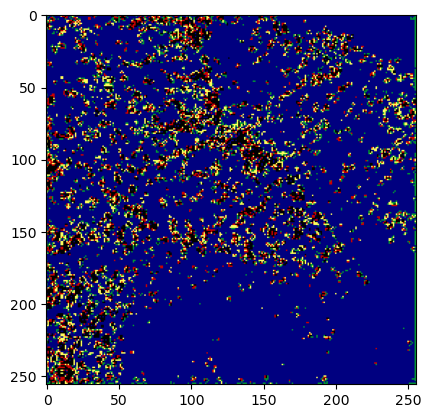

In [50]:
plt.imshow(rgb_images_pred[1])

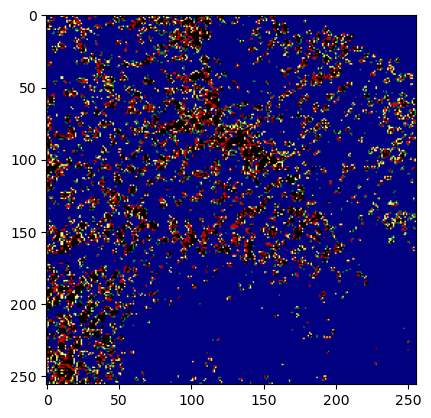

In [51]:
plt.imshow(rgb_real[1])

In [52]:
from tensorflow.keras.models import save_model
save_model(model, 'unet_model_96.89.h5')

In [53]:
from PIL import Image

In [54]:
gt_output_dir = '/kaggle/working/ground_truth'
pred_output_dir = '/kaggle/working/predicted'

In [55]:
os.makedirs(gt_output_dir, exist_ok=True)
os.makedirs(pred_output_dir, exist_ok=True)

In [56]:
for i, rgb_rl in enumerate(rgb_real):
    pil_image = Image.fromarray(rgb_rl)
    image_filename = os.path.join(gt_output_dir, f'gt_image_{i}.png')
    pil_image.save(image_filename)
    print(f'Saved ground truth image: {image_filename}')

Saved ground truth image: /kaggle/working/ground_truth/gt_image_0.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_1.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_2.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_3.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_4.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_5.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_6.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_7.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_8.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_9.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_10.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_11.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_12.png
Saved ground truth image: /kaggle/working/ground_truth/gt_image_13.png
Saved ground tru

In [57]:
for i, pred_image in enumerate(rgb_images_pred):
    pil_image = Image.fromarray(pred_image)
    image_filename = os.path.join(pred_output_dir, f'pred_image_{i}.png')
    pil_image.save(image_filename)
    print(f'Saved predicted image: {image_filename}')

Saved predicted image: /kaggle/working/predicted/pred_image_0.png
Saved predicted image: /kaggle/working/predicted/pred_image_1.png
Saved predicted image: /kaggle/working/predicted/pred_image_2.png
Saved predicted image: /kaggle/working/predicted/pred_image_3.png
Saved predicted image: /kaggle/working/predicted/pred_image_4.png
Saved predicted image: /kaggle/working/predicted/pred_image_5.png
Saved predicted image: /kaggle/working/predicted/pred_image_6.png
Saved predicted image: /kaggle/working/predicted/pred_image_7.png
Saved predicted image: /kaggle/working/predicted/pred_image_8.png
Saved predicted image: /kaggle/working/predicted/pred_image_9.png
Saved predicted image: /kaggle/working/predicted/pred_image_10.png
Saved predicted image: /kaggle/working/predicted/pred_image_11.png
Saved predicted image: /kaggle/working/predicted/pred_image_12.png
Saved predicted image: /kaggle/working/predicted/pred_image_13.png
Saved predicted image: /kaggle/working/predicted/pred_image_14.png
Saved